# Train Zero Shot Text Classification with SetFit on Argilla Labeler

- **Goal**: Show a standard workflow for a text classification task, including zero-shot suggestions and model fine-tuning.
- **Dataset**: [IMDB](https://huggingface.co/datasets/stanfordnlp/imdb), a dataset of movie reviews that need to be classified as positive or negative.
- **Libraries**: [datasets](https://github.com/huggingface/datasets), [transformers](https://github.com/huggingface/transformers), [setfit](https://github.com/huggingface/setfit)
- **Components**: [TextField](https://docs.argilla.io/latest/reference/argilla/settings/fields/#src.argilla.settings._field.TextField), [LabelQuestion](https://docs.argilla.io/latest/reference/argilla/settings/questions/#src.argilla.settings._question.LabelQuestion), [Suggestion](https://docs.argilla.io/latest/reference/argilla/records/suggestions/), [Query](https://docs.argilla.io/dev/reference/argilla/search/#rgquery_1), [Filter](https://docs.argilla.io/dev/reference/argilla/search/#rgfilter)

## Getting started

### Deploy the Argilla server

If you already have deployed Argilla, you can skip this step. Otherwise, you can quickly deploy Argilla following [this guide](../getting_started/quickstart.md).

### Set up the environment

To complete this tutorial, you need to install the Argilla SDK and a few third-party libraries via `pip`.

# Argilla Labeler 

In [21]:
!pip install ipywidgets


  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
!pip install -U "git+https://github.com/argilla-io/distilabel.git@fix/simplified-prompt-template-argilla-labeller#egg=distilabel[llama_cpp]"

DEPRECATION: git+https://github.com/argilla-io/distilabel.git@fix/simplified-prompt-template-argilla-labeller#egg=distilabel[llama_cpp] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/argilla-io/distilabel.git (to revision fix/simplified-prompt-template-argilla-labeller) to /private/var/folders/8z/jnnncfnj7_lfxym0262z4p180000gn/T/pip-install-z047oxvm/distilabel_ef385863b5484cea8f5bd96bddb41a8e
  Running command git clone --filter=blob:none --quiet https://github.com/argilla-io/distilabel.git /private/var/folders/8z/jnnncfnj7_lfxym0262z4p180000gn/T/pip-install-z047oxvm/distilabel_ef385863b5484cea8f5bd96bddb41a8e
  Running command git checkout -b fix/simplified-prompt-template-argilla-labeller --track origin/fix/simplified-prompt-template-argilla-labeller
  Switche

In [69]:
import os
from uuid import uuid4

import argilla as rg

client = rg.Argilla()

labels = ["positive", "negative", "neutral"]

settings = rg.Settings(
    guidelines="Label the sentiment of the text",
    fields=[
        rg.TextField(
            name="text",
            title="Text",
            description="A review of a pc component",
        )
    ],
    questions=[
        rg.LabelQuestion(
            name="sentiment",
            title="sentiment",
            description="Provide a single label for the sentiment of the text",
            labels=labels,
        )
    ],
    # mapping={"sentiment": "label"},
)

dataset_name = f"pc-component-{uuid4()}"

dataset = rg.Dataset.from_hub(
    repo_id="argilla/pc-components-reviews",
    name=dataset_name,
    split="train[:20]",
    client=client,
    with_records=True,
    settings=settings,
)

/Users/ben/code/argilla-cookbook/.venv/lib/python3.11/site-packages/argilla/datasets/_resource.py:264: UserWarning: Workspace not provided. Using default workspace: argilla id: 108b045c-a82e-4c75-a61b-0cddfb22c4c8
  warnings.warn(f"Workspace not provided. Using default workspace: {workspace.name} id: {workspace.id}")
/Users/ben/code/argilla-cookbook/.venv/lib/python3.11/site-packages/argilla/records/_mapping/_mapper.py:89: UserWarning: Keys ['instruction', 'gender', 'age_group', 'nationality', 'expertise', 'language', 'distilabel_metadata', 'model_name', 'labels'] in data are not present in the mapping and will be ignored.
  warnings.warn(f"Keys {unknown_keys} in data are not present in the mapping and will be ignored.")


DatasetRecords: The provided batch size 256 was normalized. Using value 20.

Sending records...: 100%|██████████| 1/1 [00:00<00:00,  3.50batch/s]


In [70]:
## ADD WITHOUT SUGGESTIONS

# from datasets import load_dataset

# updated_records = []

# for sample in load_dataset("argilla/pc-components-reviews", split="train[20:40]"):
#     _record = {
#         "text": sample["text"],
#     }
#     updated_records.append(_record)

# dataset.records.log(updated_records)

DatasetRecords: The provided batch size 256 was normalized. Using value 20.

Sending records...: 100%|██████████| 1/1 [00:00<00:00,  3.09batch/s]


DatasetRecords(Dataset(id=UUID('a27327ea-2ee4-4b44-afcb-ed19724a3866') inserted_at=datetime.datetime(2024, 10, 14, 9, 23, 11, 205431) updated_at=datetime.datetime(2024, 10, 14, 9, 23, 11, 818327) name='pc-component-1b5a4aff-9bc9-4b27-8cec-bc21b57b3e34' status='ready' guidelines='Label the sentiment of the text' allow_extra_metadata=False distribution=OverlapTaskDistributionModel(strategy='overlap', min_submitted=1) workspace_id=UUID('108b045c-a82e-4c75-a61b-0cddfb22c4c8') last_activity_at=datetime.datetime(2024, 10, 14, 9, 23, 11, 818327)))

## Label the datasets

We will now label the datasets. We will use the `ArgillaLabeller` class to label the datasets. This class will use  will use a `LlamaCppLLM` LLM to label the datasets. These labels will then be converted into `rg.Suggestion` objects and added to the records. For the sake of the example, we will only label 5 records per time using a while loop that continuesly fetches pending records from Argilla for both datasets and labels them with the LLM. After the labelling, we will update the dataset with the new records.

In [23]:
from collections import Counter
from distilabel.llms.llamacpp import LlamaCppLLM
from distilabel.steps.tasks import ArgillaLabeller

dataset = client.datasets(name=dataset_name, workspace="argilla")

example_records = []

counter = Counter()
max_samples = 16


for record in dataset.records(with_responses=True, with_suggestions=True):
    value = record.suggestions["sentiment"].value
    counter[value] += 1
    if counter[value] > 12:
        continue
    record.responses.add(
        rg.Response(question_name="sentiment", value=value, user_id=client.me)
    )
    example_records.append(record)

In [24]:
example_records = [record.to_dict() for record in example_records]

In [25]:
len(example_records)

20

In [26]:
# randomly shuffle the records

import random

random.shuffle(example_records)

# Distilabel can label your records

We can use the `process` method of the `ArgillaLabeller` class to label the records. This method will label the records with the LLM and update the records with the new labels. We will use this method to label the records of the datasets.

In [27]:
from datasets import load_dataset

train_dataset = load_dataset("argilla/pc-components-reviews", split="train[:20]")

train_dataset = train_dataset.remove_columns(
    [col for col in train_dataset.column_names if col not in ["text", "sentiment"]]
)

test_dataset = load_dataset("argilla/pc-components-reviews", split="train[20:100]")

test_dataset = test_dataset.remove_columns(
    [col for col in test_dataset.column_names if col not in ["text", "sentiment"]]
)

In [28]:
train_dataset.to_pandas()

,sentiment,text
0,positive,I finally got my hands on the Ryzen 9 7950X an...
1,positive,I recently bought the Intel Core i5-10400F and...
2,positive,I just upgraded to the Ryzen 9 5950X and it's ...
3,positive,I just swapped out my old GPU for the RTX 4070...
4,negative,I just upgraded to the new Intel Core i9-13900...
5,neutral,"Just got the new Intel Core i9-13900K, and I m..."
6,negative,I just got the new Ryzen 5 5600X and it’s not ...
7,positive,Just built my new rig with the Ryzen 5 5600X a...
8,neutral,I recently upgraded my PC with the AMD Ryzen 5...
9,positive,I just built my first PC with an AMD Ryzen 5 3...


In [29]:
from distilabel.llms import InferenceEndpointsLLM
from huggingface_hub import notebook_login

# notebook_login()

In [30]:
results_scores = {}
max_eval_records = 100

for n_samples in [0, 4, 8, 16]:
    # Initialize the labeller with the model and fields
    labeller = ArgillaLabeller(
        llm=InferenceEndpointsLLM(
            model_id="meta-llama/Meta-Llama-3.1-8B-Instruct",
            tokenizer_id="meta-llama/Meta-Llama-3.1-8B-Instruct",
            generation_kwargs={"max_new_tokens": 1024 * 4},
        ),
        example_records=example_records[: n_samples + 1],
    )
    labeller.load()
    predictions = []
    true = []
    results = labeller.process(
        [
            {
                "record": rg.Record(fields={"text": sample["text"]}),
                "fields": dataset.fields,
                "question": dataset.questions[0],
                "guidelines": dataset.guidelines,
            }
            for sample in test_dataset
        ]
    )
    for sample, result in zip(test_dataset, next(results)):
        true.append(sample["sentiment"])
        if not result["suggestion"]:
            predictions.append(None)
            continue

        suggestion = result["suggestion"]["value"]
        predictions.append(suggestion)

    results_scores[n_samples] = {"true": true, "predictions": predictions}

    del labeller

In [ ]:
llm_results = {}

for n_samples, data in results_scores.items():
    true = data["true"]
    predictions = data["predictions"]

    acc = sum([t == p for t, p in zip(true, predictions) if p is not None]) / len(
        [p for p in predictions if p is not None]
    )

    print(f"Accuracy for {n_samples} samples: {acc}")
    llm_results[n_samples] = {"accuracy": acc}


# SetFit Efficient Classifier

Let's make the required imports:

In [38]:
from datasets import load_dataset, Dataset
from setfit import (
    SetFitModel,
    Trainer,
    get_templated_dataset,
    sample_dataset,
    TrainingArguments,
)

In [39]:
train_dataset = train_dataset.rename_column("sentiment", "label")
test_dataset = test_dataset.rename_column("sentiment", "label")

In [40]:
def train_model(
    model_name,
    eval_dataset,
    train_dataset=None,
):
    model = SetFitModel.from_pretrained(model_name)

    args = TrainingArguments(
        num_epochs=1,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    if train_dataset is None or len(train_dataset) == 0:
        print("Sampling dataset for zero shot")
        train_dataset = get_templated_dataset(
            candidate_labels=labels,
        )
        eval_dataset = eval_dataset.map(lambda x: {"label": labels.index(x["label"])})

    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        # args=args,
    )

    trainer.train()

    results = trainer.evaluate()

    print(results)

    return model, results

Let's train the model. We will use `TaylorAI/bge-micro-v2`, available in the [Hugging Face Hub](https://huggingface.co/TaylorAI/bge-micro-v2).

In [41]:
model, results = train_model(
    model_name="TaylorAI/bge-micro-v2", eval_dataset=test_dataset
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Sampling dataset for zero shot


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 24
  Batch size = 16
  Num epochs = 1


  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.2891, 'grad_norm': 1.4333018064498901, 'learning_rate': 2e-05, 'epoch': 0.5}


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

***** Running evaluation *****


{'train_runtime': 0.3945, 'train_samples_per_second': 60.831, 'train_steps_per_second': 5.069, 'train_loss': 0.2889108806848526, 'epoch': 1.0}
{'accuracy': 0.4875}


In [42]:
train_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 20
})

You can save it locally or push it to the Hub. And then, load it from there.

In [ ]:
results_scores = {}

for n_samples in [0, 4, 8, 16]:

    _train_dataset = sample_dataset(
        dataset=train_dataset, label_column="label", num_samples=n_samples
    )
    print(f"Results for {n_samples} samples:")
    model, results = train_model(
        model_name="TaylorAI/bge-micro-v2",
        train_dataset=_train_dataset,
        eval_dataset=test_dataset,
    )
    results_scores[n_samples] = results

In [44]:
# Save and load locally
# model.save_pretrained("text_classification_model")
# model = SetFitModel.from_pretrained("text_classification_model")

# Push and load in HF

model.push_to_hub(repo_id="argilla/pc_components_classifier")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model_head.pkl:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/argilla/pc_components_classifier/commit/5c471988d1019eec0ec7f13a076e62b9d3f90c72', commit_message='Push model using huggingface_hub.', commit_description='', oid='5c471988d1019eec0ec7f13a076e62b9d3f90c72', pr_url=None, repo_url=RepoUrl('https://huggingface.co/argilla/pc_components_classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='argilla/pc_components_classifier'), pr_revision=None, pr_num=None)

In [46]:
import pandas as pd

df = pd.DataFrame(results_scores).T

df = df.rename(columns={"accuracy": "SetFit-TaylorAI/bge-micro-v2"})


df.at[0, "LlaMA-3.1-8b-zero-shot"] = 0.5875
df.at[4, "LlaMA-3.1-8b-zero-shot"] = 0.6125
df.at[8, "LlaMA-3.1-8b-zero-shot"] = 0.625
df.at[16, "LlaMA-3.1-8b-zero-shot"] = 0.765

<Axes: title={'center': 'Accuracy vs Number of samples'}, xlabel='Number of samples', ylabel='Accuracy'>

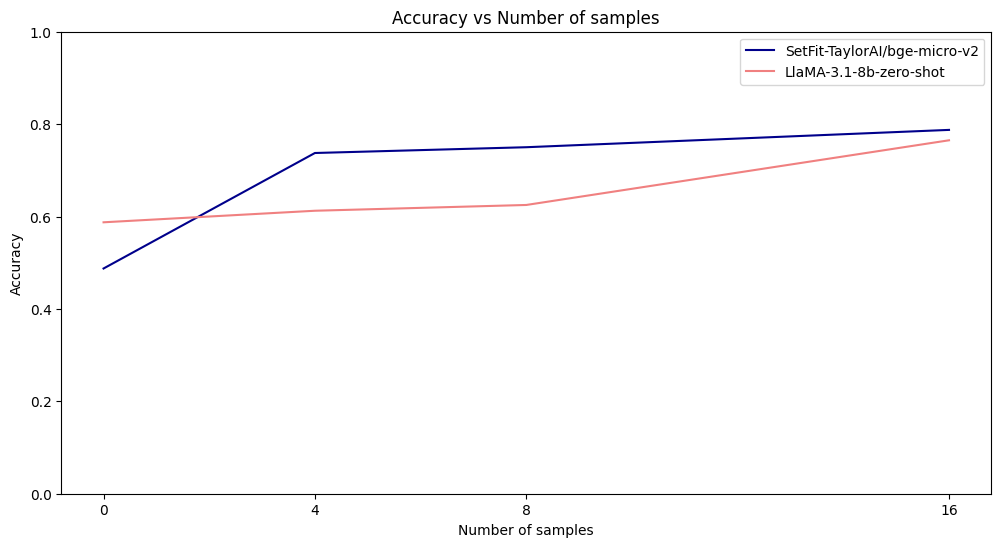

In [53]:
df.plot(
    xlabel="Number of samples",
    ylabel="Accuracy",
    title="Accuracy vs Number of samples",
    xticks=[0, 4, 8, 16],
    yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    color=["darkblue", "lightcoral"],
    figsize=(12, 6),
)